In [1]:
from cities.deployment.tracts_minneapolis.predict import TractsModelPredictor

from cities.utils.plot_ts import (plot_coefs, summarize_time_series,
                                  plot_model_summary, plot_selected_series)

from chirho.indexed.ops import IndexSet, gather, indices_of

from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.interventional.handlers import do

from cities.utils.data_loader import db_connection
import time
import torch
import pyro


import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
start = time.time()
with db_connection() as conn:
    predictor = TractsModelPredictor(conn)

end = time.time()
print("Time elapsed:", end - start)

Time elapsed: 11.756484270095825


In [3]:
predictor.train_model(override=False, num_steps=4000)

The model has already been trained. Set 'override' to True to retrain the model.


/home/rafal/s78projects/cities/cities/utils/plot_ts.py:244: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


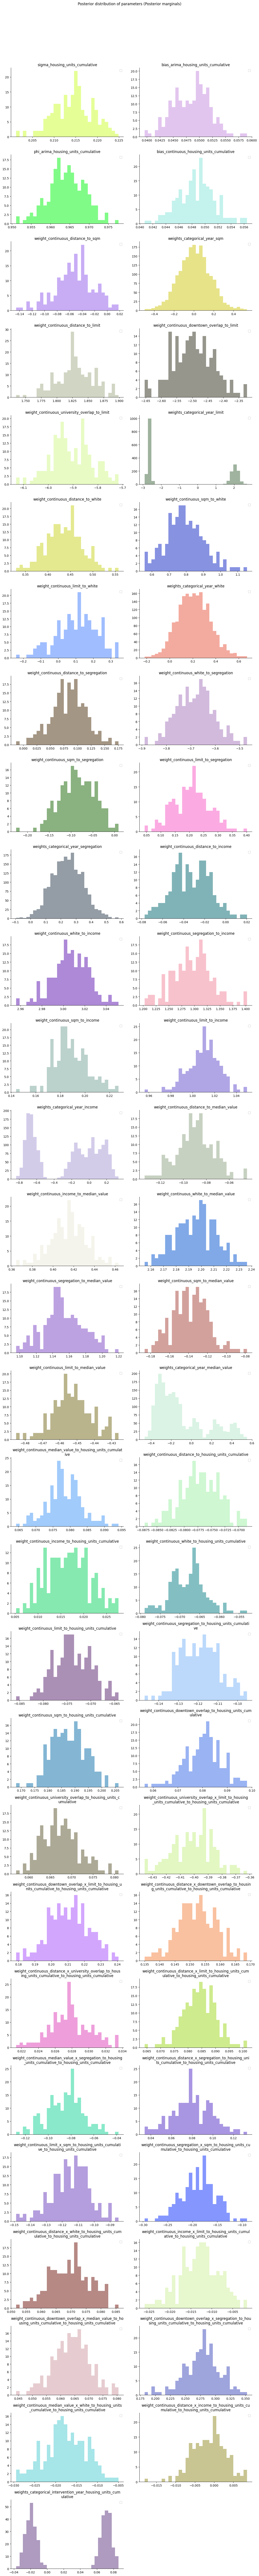

In [4]:
factual_samples = predictor.predictive(data = predictor.nonified_data) 

specific_names = ['sigma_housing_units_cumulative', 'bias_arima_housing_units_cumulative', 'phi_arima_housing_units_cumulative', 'bias_continuous_housing_units_cumulative']
weigth_names = [name for name in factual_samples.keys() if name.startswith("weight")]
param_sites = specific_names + weigth_names

assert all(name in factual_samples.keys() for name in param_sites)

plot_coefs(factual_samples, param_sites, true_params=None, title="Posterior marginals")

['weights_categorical_intervention_year_housing_units_cumulative']


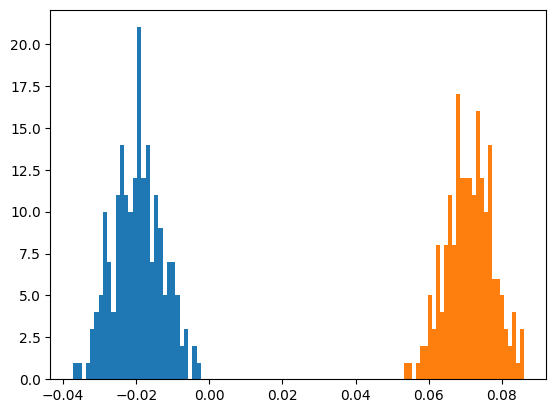

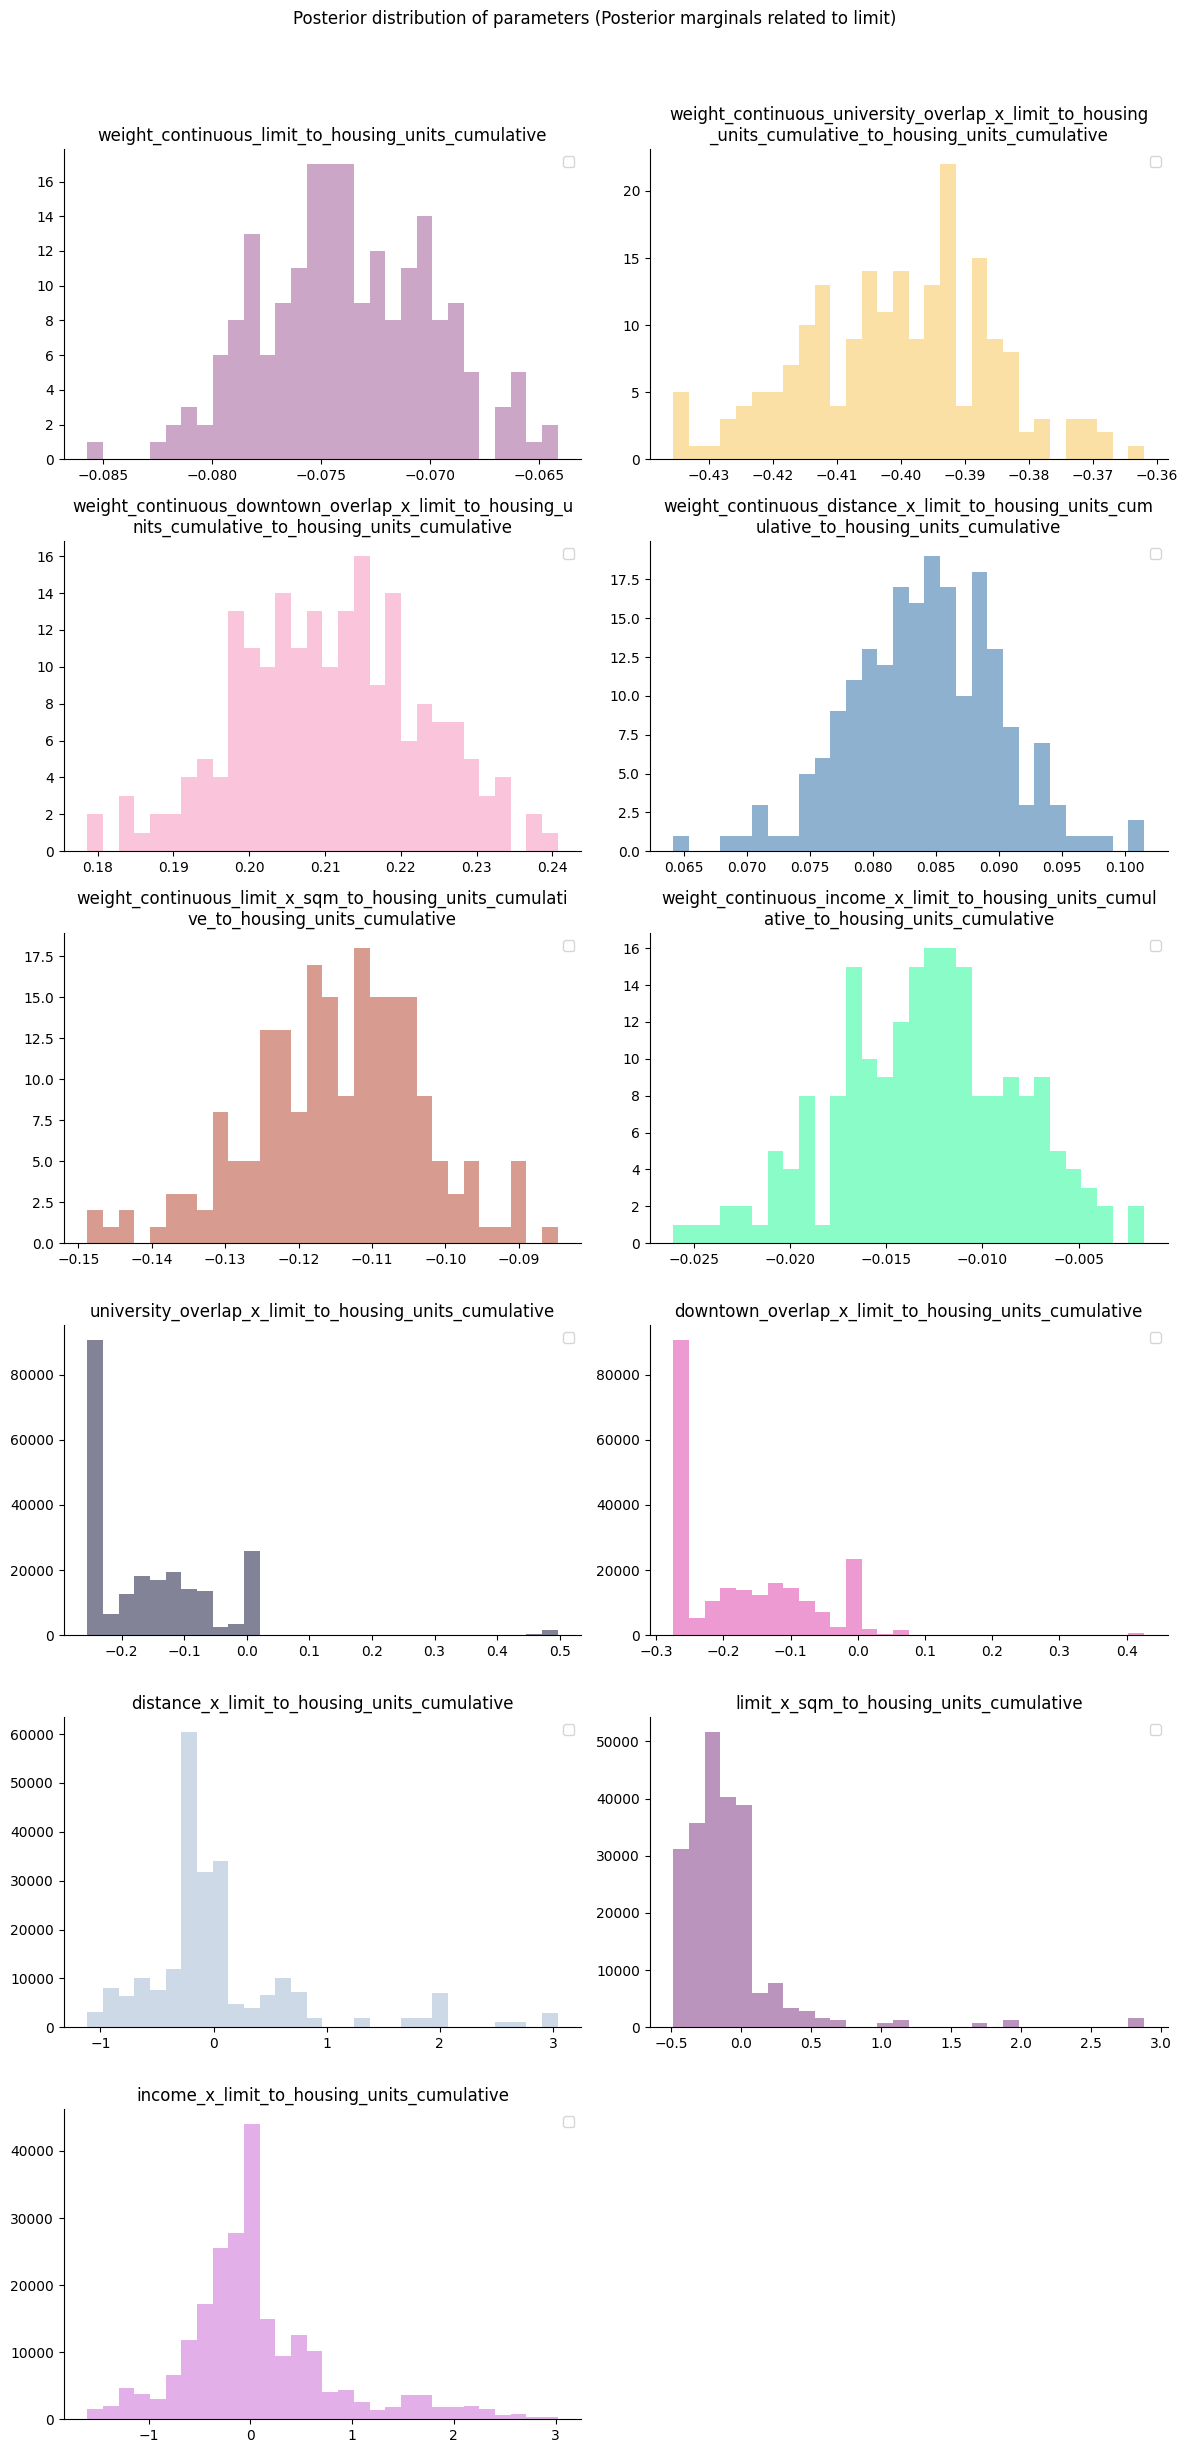

In [5]:
y_keys = [name for name in factual_samples.keys() if "year" in name and "housing" in name]
l_keys = [name for name in factual_samples.keys() if "limit" in  name and "housing" in name]

print(y_keys)

categorical_weights = factual_samples[y_keys[0]]   

for i in range(categorical_weights.shape[-1]):
    plt.hist(categorical_weights[...,i].flatten(), bins=30, label = f'category {i}')

#     plt.hist(factual_samples['weights_categorical_year_housing_units_cumulative'][...,i].flatten(), bins=30, label = f'year {i+2010}')
# plt.legend()
# plt.show()


plot_coefs(factual_samples, l_keys, true_params=None, title="Posterior marginals related to limit")

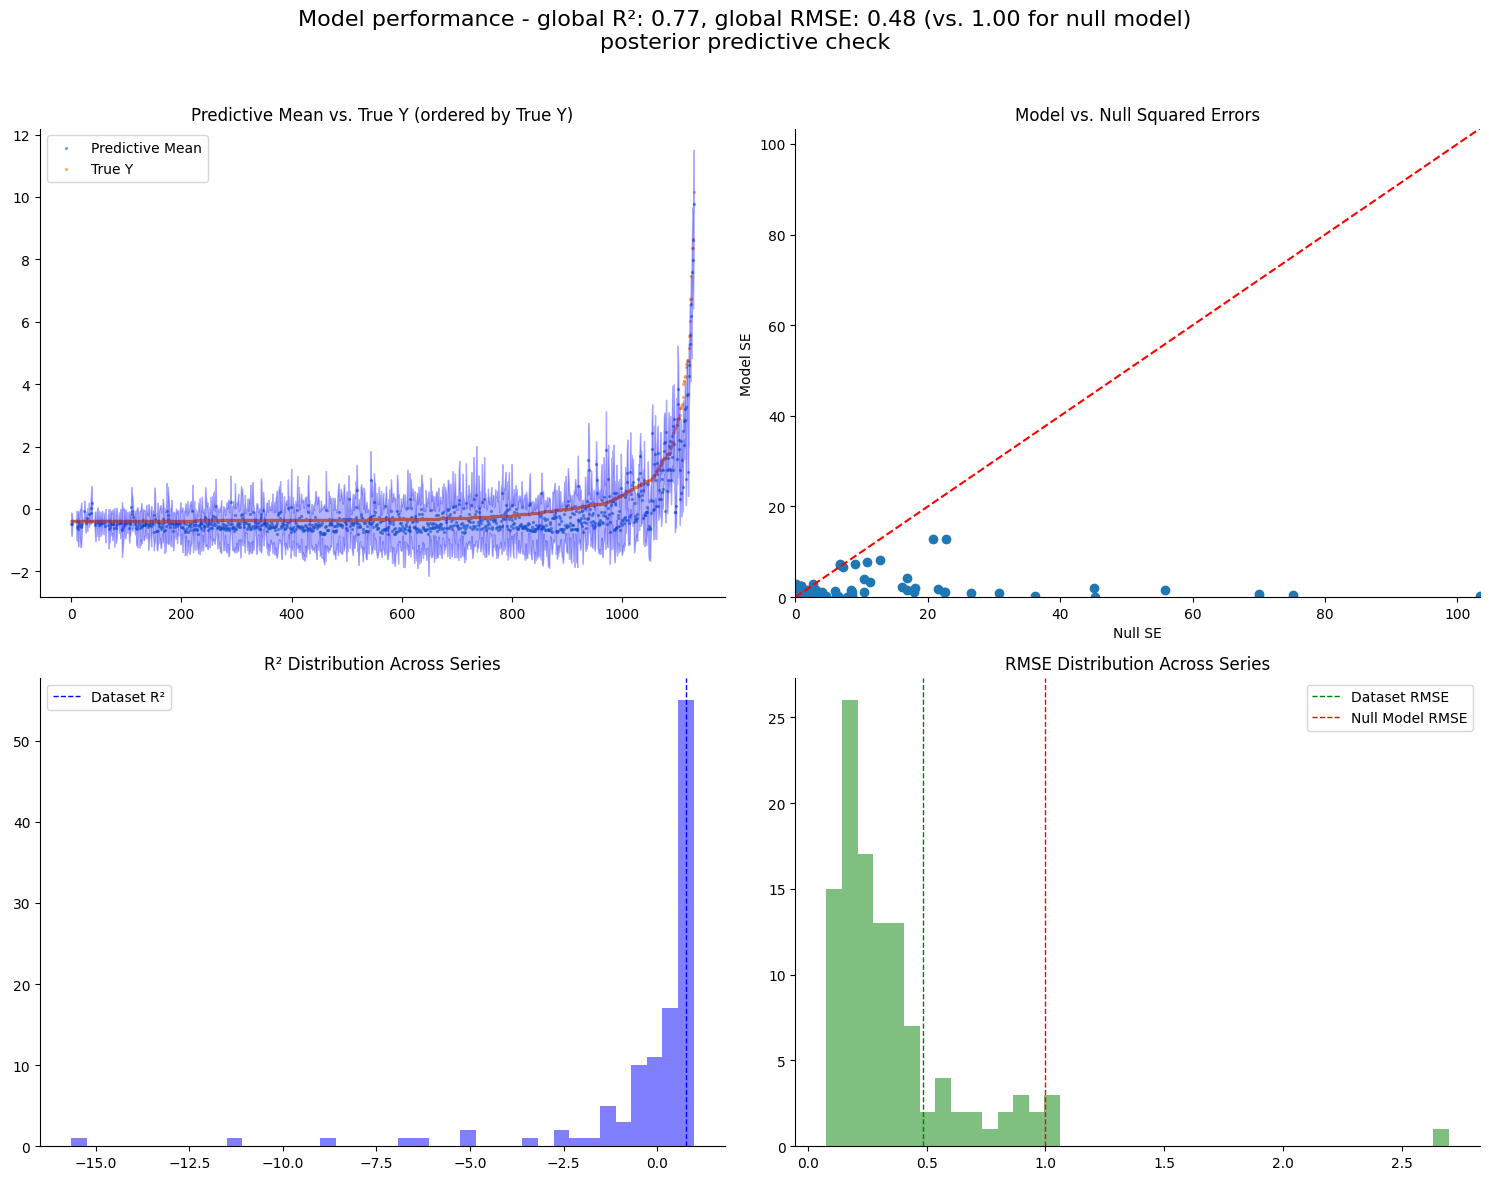

In [6]:
y_true = predictor.data['reshaped']['continuous']['housing_units_cumulative']
summary = summarize_time_series(factual_samples, y_true, y_site="predicted_housing_units_cumulative")
plot_model_summary(summary, y_true, title="posterior predictive check", 
                   path = "cumulative model evaluation.png")

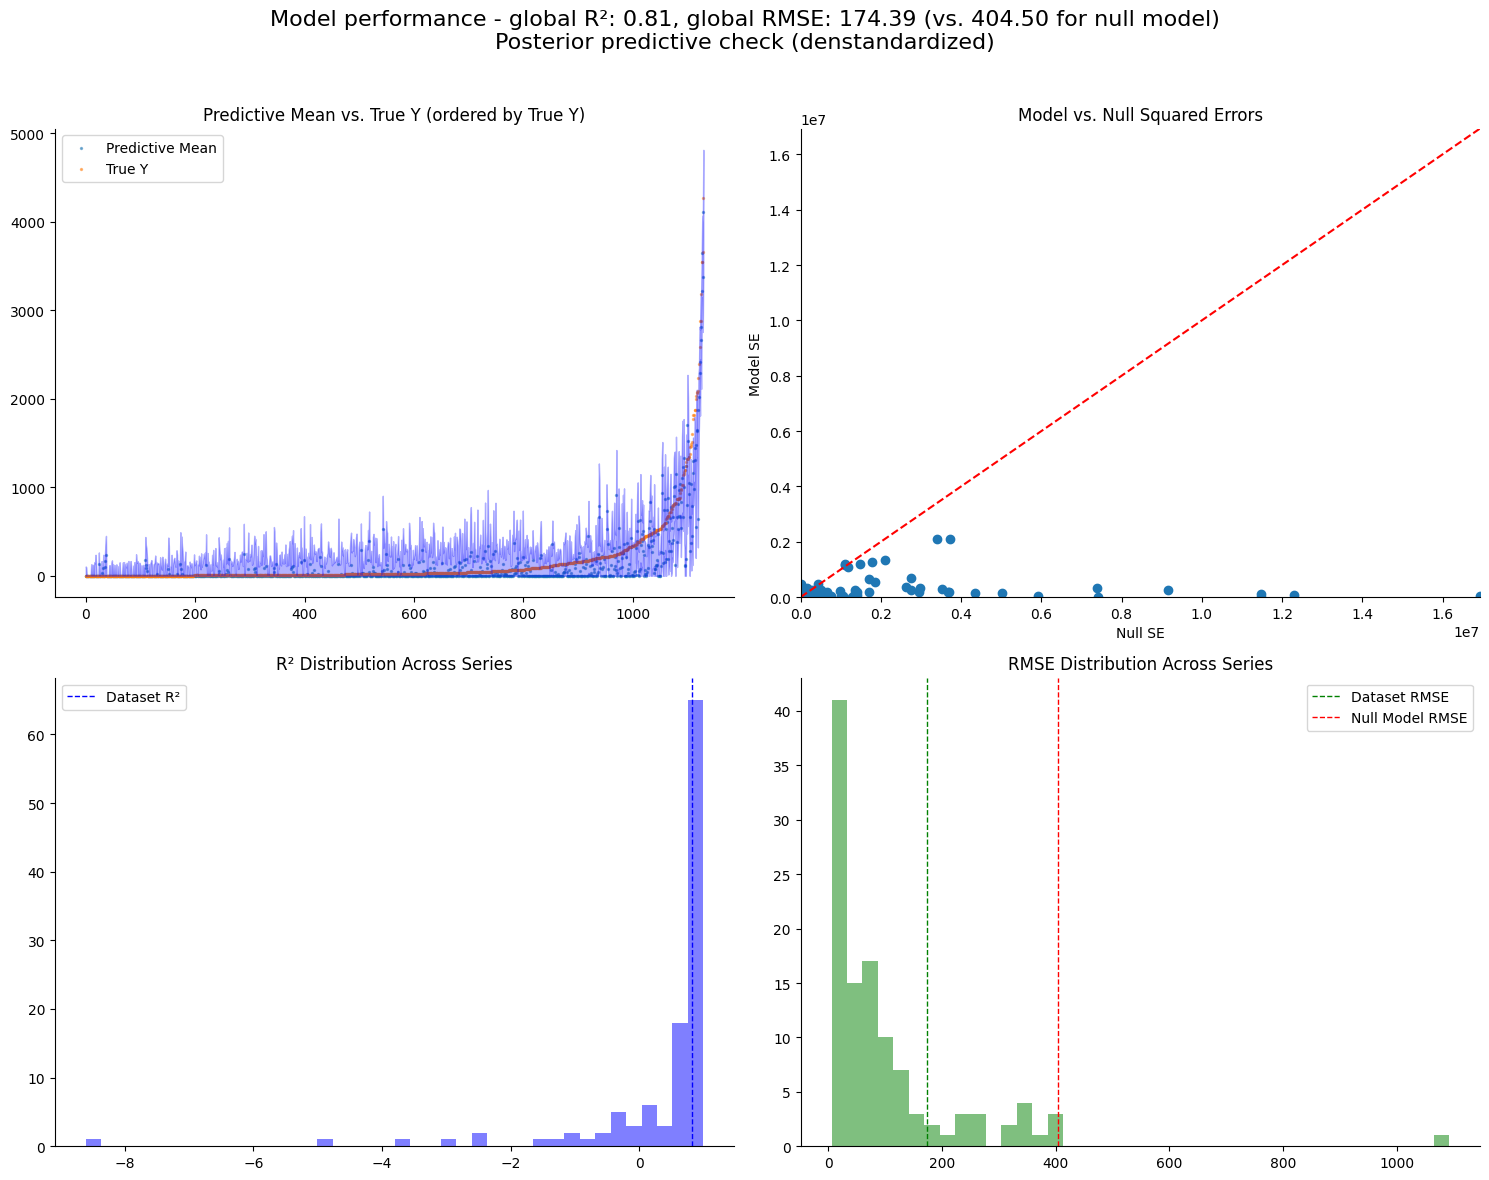

In [7]:
y_true_original = predictor.data['reshaped']['continuous']['housing_units_cumulative_original']

factual_samples['destandardized_housing_units_cumulative'] = (factual_samples['predicted_housing_units_cumulative'] *
                                                predictor.data['housing_units_cumulative_std'] +
                                                predictor.data['housing_units_cumulative_mean'])


summary_destandardized = summarize_time_series(factual_samples,
                                y_true_original, y_site="destandardized_housing_units_cumulative",
                                clamp_at_zero=True)

plot_model_summary(summary_destandardized, y_true_original, 
                   title="Posterior predictive check (denstandardized)",
                   path = "ts_model_summary_cumulative.png")

# with year: .82, 173, vs 404 but years overshadow limit

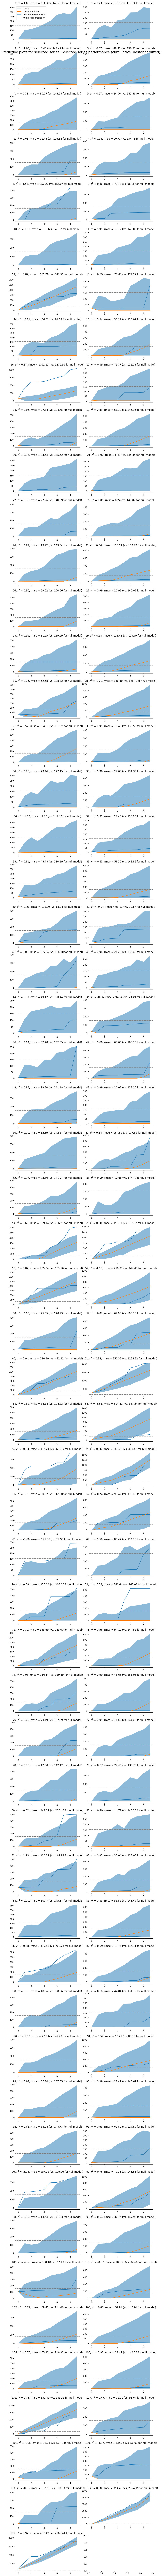

In [8]:
plot_selected_series(
    summary_destandardized,
    y_true = y_true_original,
    selected_series=range(113),
    title="Selected series performance (cumulative, destandardized)",
    plot_null=True,
    path = "ts_selected_series_destandardized_cumulative.png"
)

[]

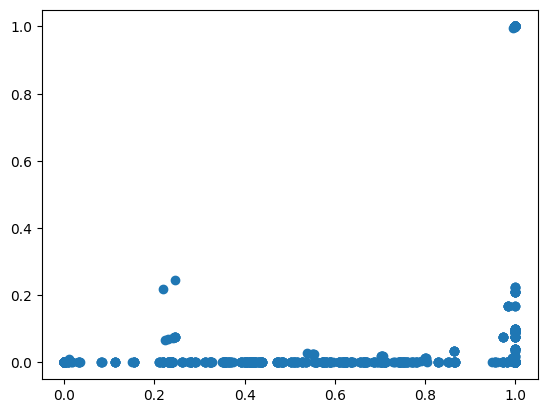

In [9]:
factual_intervention = {"radius_blue": 106.7, "limit_blue": 0, "radius_yellow_line": 402.3, "radius_yellow_stop": 804.7, "limit_yellow": 0.5, "reform_year": 2015}
extreme_intervention = {"radius_blue": 1400, "limit_blue": 0, "radius_yellow_line": 2640, "radius_yellow_stop": 4000, "limit_yellow": 0.3, "reform_year": 2012}


with db_connection() as conn:
    predictor = TractsModelPredictor(conn)
    factual_intervention = predictor._tracts_intervention(conn, **factual_intervention)
    extreme_intervention = predictor._tracts_intervention(conn, **extreme_intervention)


plt.scatter(factual_intervention, extreme_intervention)
plt.plot()

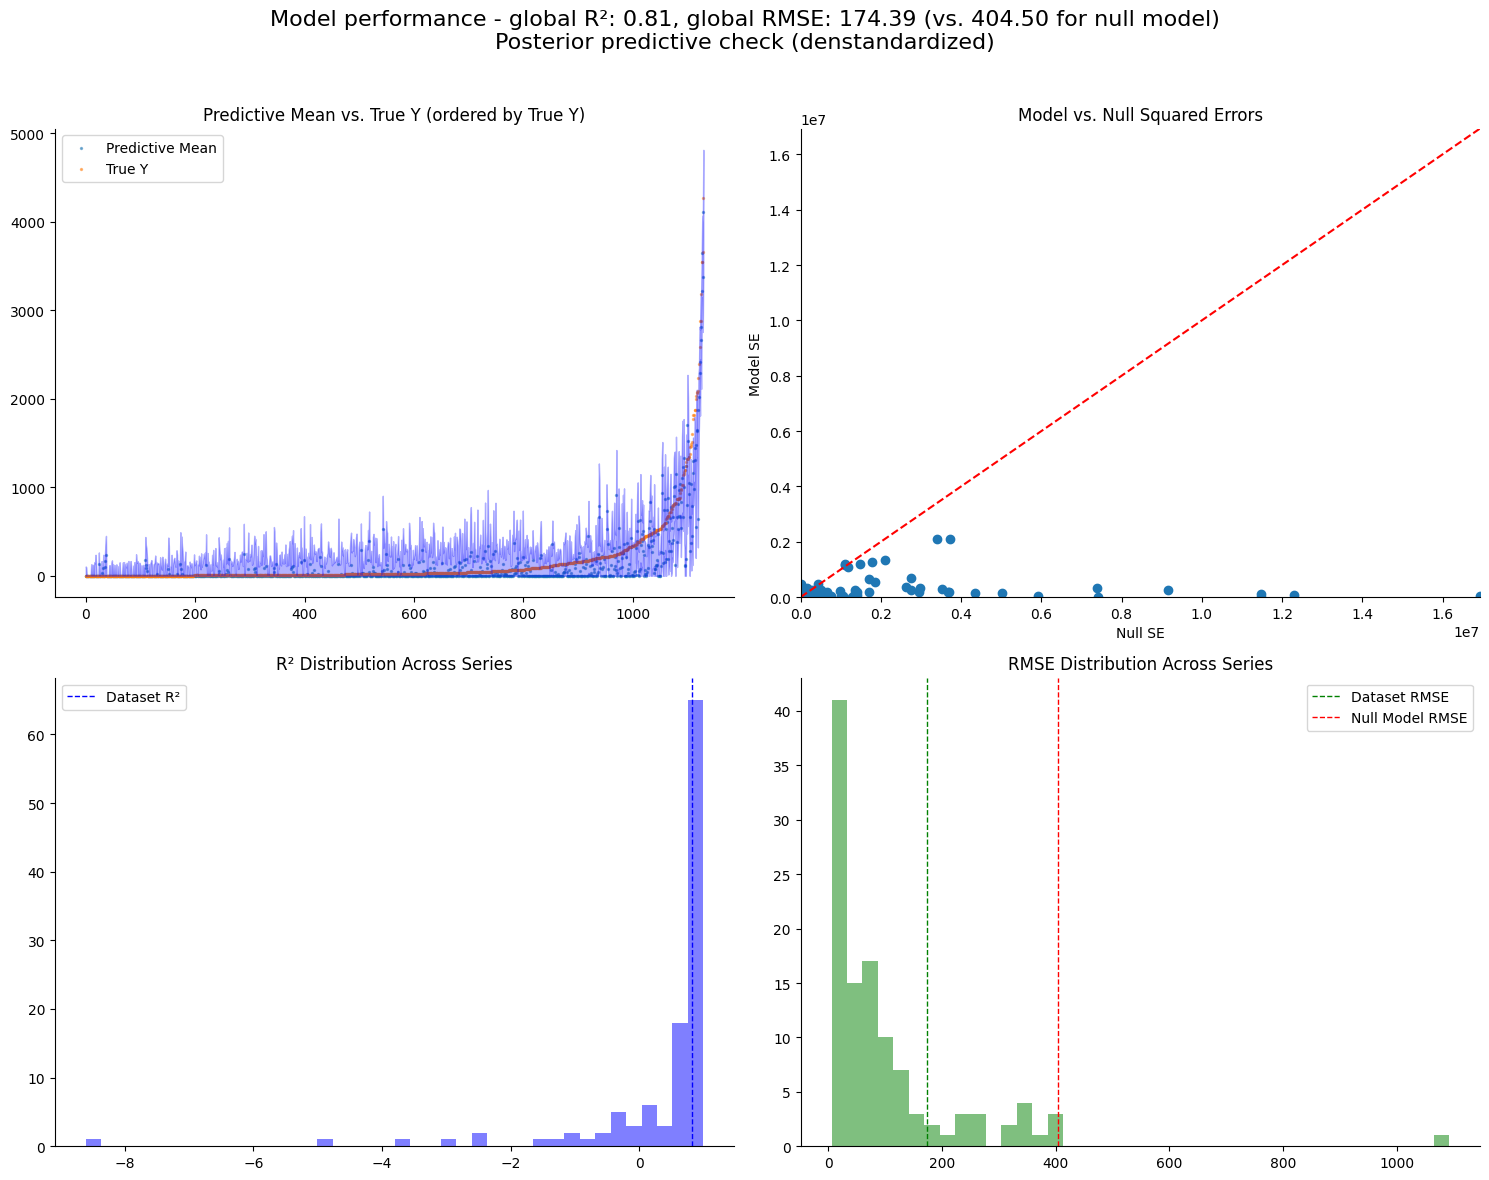

dict_keys(['mean_pred', 'mean_low', 'mean_high', 'series_mean_pred', 'series_low_pred', 'series_high_pred', 'total_null_se', 'total_model_se', 'total_r2', 'total_rmse', 'total_null_rmse', 'series_null_squared_errors', 'series_model_squared_errors', 'series_null_rmse', 'series_rmse', 'series_r2'])


[]

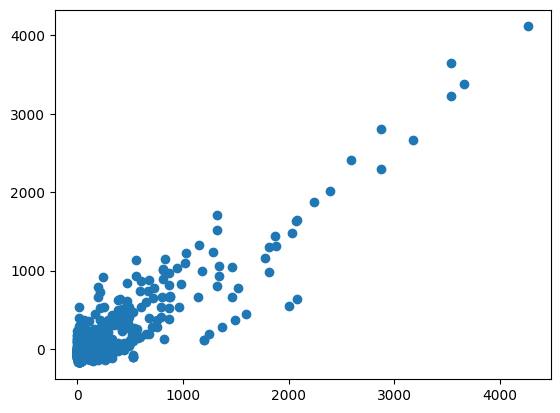

In [10]:
predictor.clear_reshaped_model_data()

with do(actions = {"limit": (factual_intervention)}):
    factual_intervention_samples =  predictor.predictive(predictor.nonified_data, 
                                        )

factual_intervention_samples['destandardized_housing_units_cumulative'] = (factual_samples['predicted_housing_units_cumulative'] *
                                                predictor.data['housing_units_cumulative_std'] +
                                                predictor.data['housing_units_cumulative_mean'])


summary_factual_intervention = summarize_time_series(
                                factual_intervention_samples,
                                y_true_original, y_site="destandardized_housing_units_cumulative",
                                clamp_at_zero=True)

plot_model_summary(summary_factual_intervention, y_true_original, 
                   title="Posterior predictive check (denstandardized)",
                   path = "ts_model_summary_cumulative.png")

print(summary_factual_intervention.keys())

plt.scatter(y_true_original,
            factual_intervention_samples['destandardized_housing_units_cumulative'].mean(dim = 0))
plt.plot()

In [11]:
predictor.clear_reshaped_model_data()

reform_year = 2012
intervention_year = reform_year - 2011

with do(actions = {"limit": (extreme_intervention)}):
    extreme_intervention_samples =  predictor.predictive(predictor.nonified_data, 
                                                         intervention_year = intervention_year )
                                        

extreme_intervention_samples['destandardized_housing_units_cumulative'] = (
                extreme_intervention_samples['predicted_housing_units_cumulative'] *
                predictor.data['housing_units_cumulative_std'] +
                predictor.data['housing_units_cumulative_mean'])

summary_extreme_intervention = summarize_time_series(
                                extreme_intervention_samples,
                                y_true_original, y_site="destandardized_housing_units_cumulative",
                                clamp_at_zero=True)


In [12]:
mean_factual, low_factual, high_factual = summary_factual_intervention['mean_pred'], summary_factual_intervention['mean_low'], summary_factual_intervention['mean_high']

mean_extreme, low_extreme, high_extreme = summary_extreme_intervention['mean_pred'], summary_extreme_intervention['mean_low'], summary_extreme_intervention['mean_high']


observed tensor([ 1314.,  5523.,  9583., 11894., 13943., 17888., 21612., 25977., 31165.,
        35157.])
factual tensor([ 1314.0000,  2721.6780,  4284.7275,  5831.4819,  8739.3086, 12087.6045,
        15635.2266, 19456.2617, 24208.1738, 29338.8203])
intervened tensor([ 1314.0000,  4518.5459,  7358.7393, 10201.8672, 13923.1162, 17911.7441,
        22106.9297, 26448.1719, 31558.8457, 36795.0938])


[]

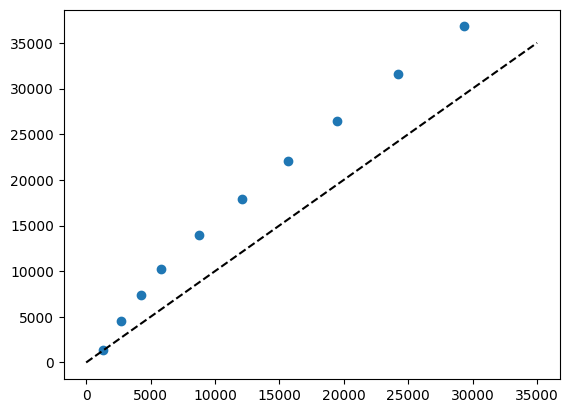

In [13]:

sum_observed = torch.sum(y_true_original, dim=0)
sum_factual = torch.sum(mean_factual, dim=0)
sum_intervened = torch.sum(mean_extreme, dim=0)

print("observed", sum_observed)
print("factual", sum_factual)
print("intervened", sum_intervened)


plt.scatter(sum_factual, sum_intervened)
plt.plot([0, 35000], [0, 35000], color='black', linestyle='--')
plt.plot()




tensor(1.) tensor(1.)


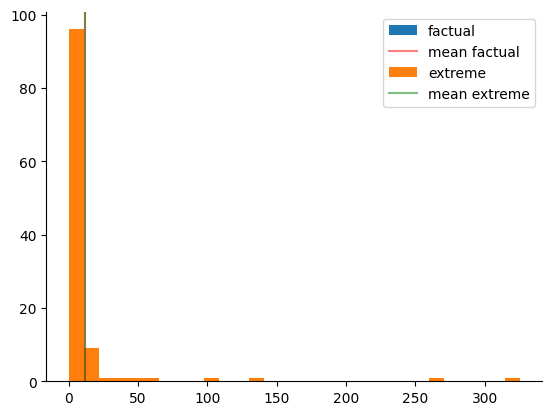

tensor(0.) tensor(10.4818)


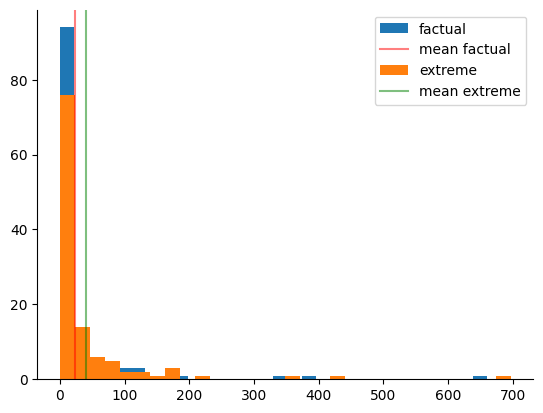

tensor(0.) tensor(12.3369)


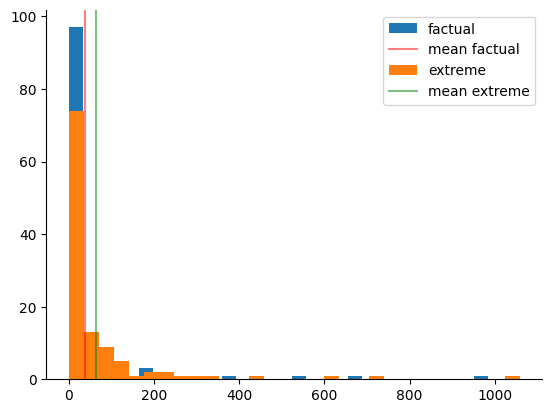

tensor(0.) tensor(16.3947)


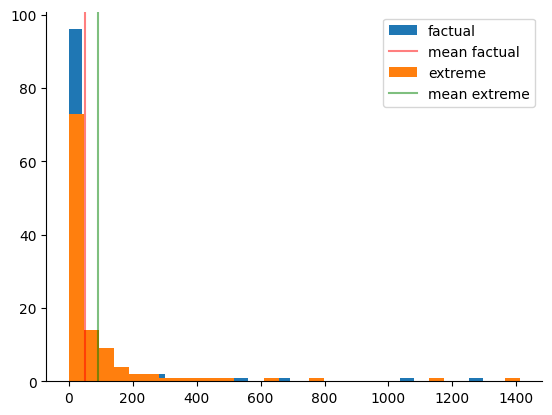

tensor(0.) tensor(32.4492)


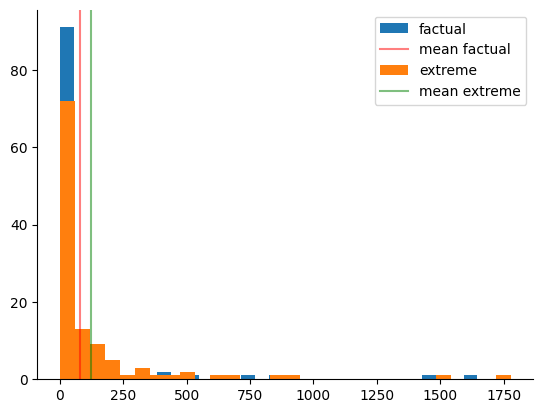

tensor(0.) tensor(51.2745)


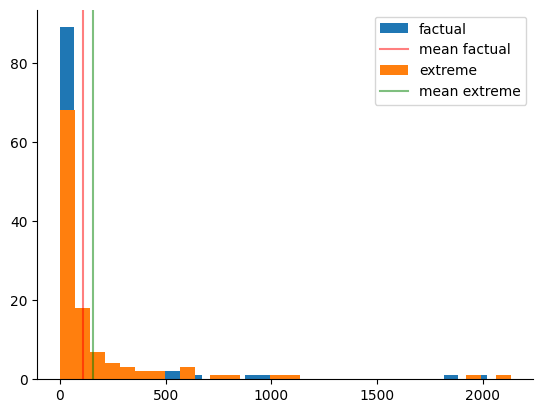

tensor(0.) tensor(74.3050)


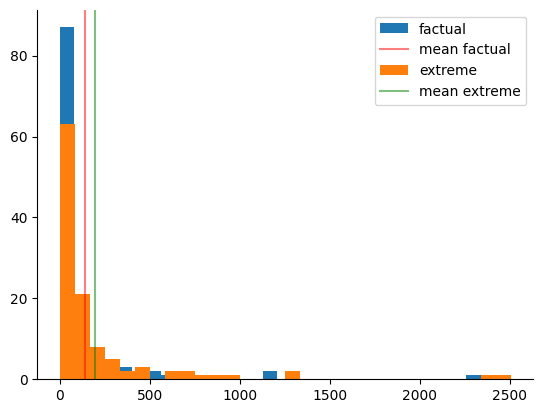

tensor(0.) tensor(99.0213)


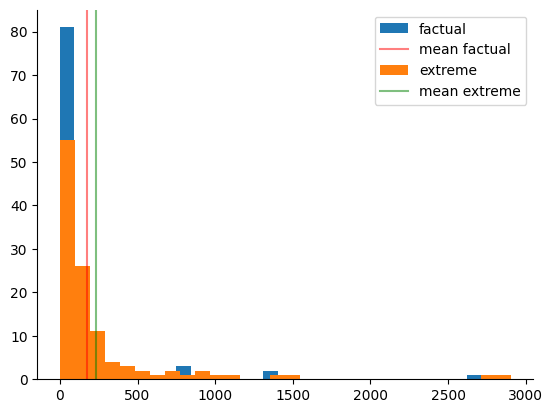

tensor(24.9097) tensor(128.9870)


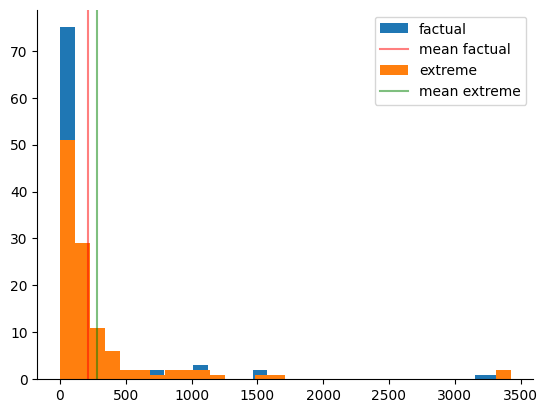

tensor(63.7366) tensor(160.5861)


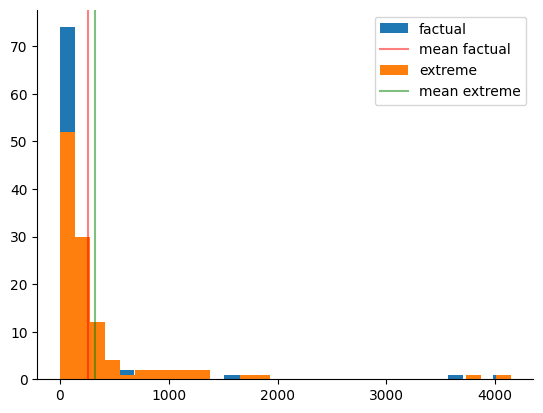

In [14]:
years_observed = predictor.data['categorical']['year_original'].unique()
years_factual = years_observed - 0.1
years_intervened = years_observed + 0.1


# years = data["categorical"]["year"].flatten().detach().numpy()
# years_full = years - 0.1
# years_no = years + 0.1





for i in range(10):
    print(mean_factual[:,i].median(), mean_extreme[:,i].median())

    plt.hist(mean_factual[:,i].flatten(), bins=30, label = "factual")
    plt.axvline(x = mean_factual[:,i].mean(), color = "red", label = "mean factual", alpha = 0.5)

    plt.hist(mean_extreme[:,i].flatten(), bins=30, label = "extreme")
    plt.axvline(x = mean_extreme[:,i].mean(), color = "green", label = "mean extreme", alpha = 0.5)

    plt.legend()
    sns.despine()
    plt.show()


torch.Size([113, 10])
torch.Size([10])


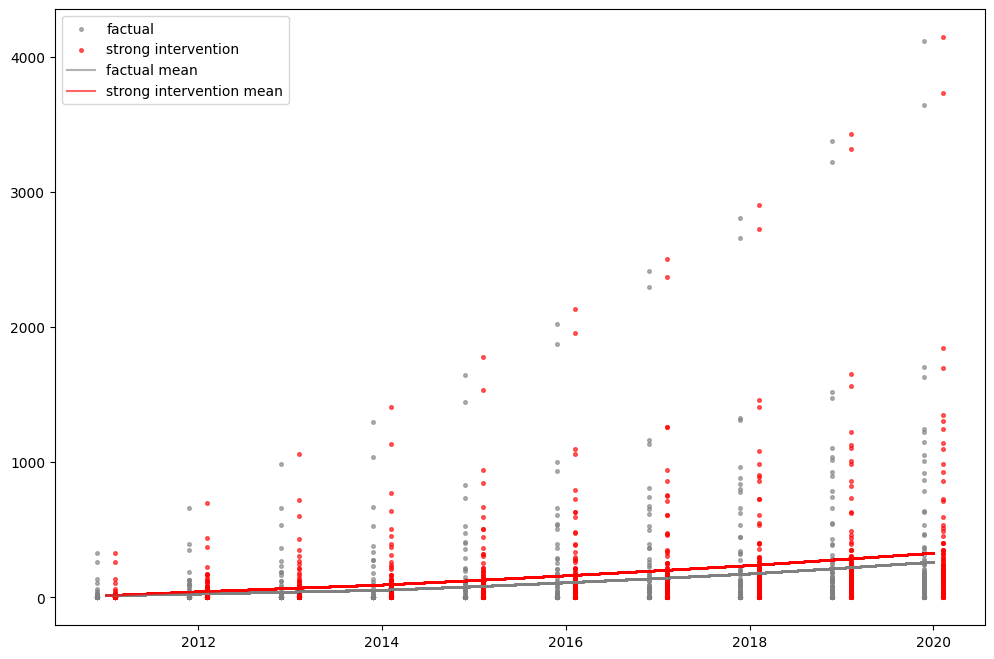

In [15]:

print(mean_factual.shape)

print(mean_factual.mean(dim = 0).shape)
plt.figure(figsize=(12, 8))

for i in range(113):
    plt.scatter(
        x = years_factual,
        y = mean_factual[i,:], 
        color = "grey",
        label = "factual" if i == 0 else None, 
        s = 7,
        alpha = 0.6
    )



    plt.scatter(
        x = years_intervened,
        y = mean_extreme[i,:], 
        color = "red",
        label = "strong intervention" if i == 0 else None, 
        s = 7,
        alpha = 0.6
    )

    plt.plot(years_observed, mean_factual.mean(dim = 0), color = "gray", label = "factual mean" if i == 0 else None, alpha = 0.6)
    plt.plot(years_observed, mean_extreme.mean(dim = 0), color = "red", label = "strong intervention mean" if i == 0 else None, alpha = 0.6)


plt.legend()
plt.show()



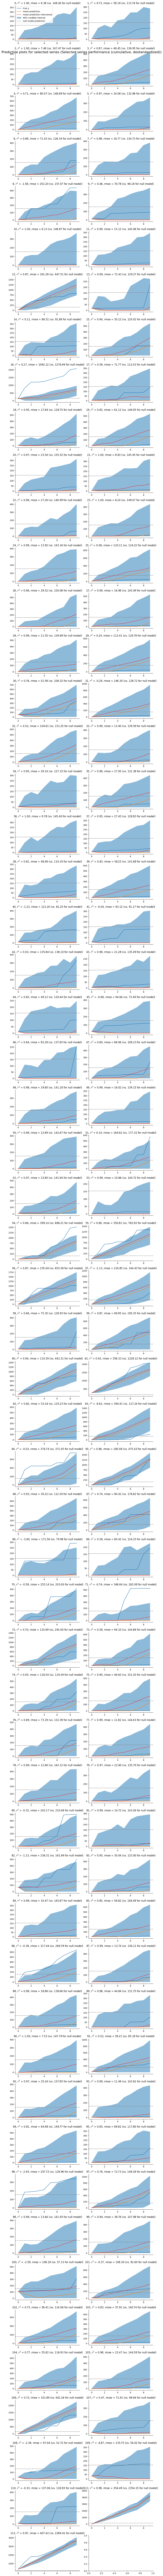

In [16]:
plot_selected_series(
    summary_factual_intervention,
    intervened_summary= summary_extreme_intervention,
    y_true = y_true_original,
    selected_series=range(113),
    title="Selected series performance (cumulative, destandardized)",
    plot_null=True,
    path = "ts_selected_series_destandardized_cumulative.png"
)